In [1]:
using Revise
# using InvariantDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations

In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
# Create KdV equation
struct KdVEquation1D <: Trixi.AbstractEquations{1 #= number of spatial dimensions =#,
                                              1 #= number of primary variables, i.e. scalar =#};
end

In [ ]:
Trixi.flux(u, orientation, equation::KdVEquation1D) = 0.5*u.^2 + 
Trixi.varnames(_, ::KdVEquation1D) = ("scalar",)

In [ ]:
initial_condition_sine(x, t, equation::CubicEquation) = SVector(sinpi(x[1]))

In [3]:
using Trixi
using DifferentialEquations

equations = InviscidBurgersEquation1D()

###############################################################################
#  setup the GSBP DG discretization that uses the Gauss operators from Chan et al.

surface_flux = flux_lax_friedrichs
volume_flux = flux_ranocha

polydeg = 3
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = density_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)
dg = DGMulti(basis,
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = volume_integral)

###############################################################################
#  setup the 1D mesh

cells_per_dimension = (32,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-1.0,), coordinates_max = (1.0,),
                   periodicity = true)

###############################################################################
#  setup the semidiscretization and ODE problem

semi = SemidiscretizationHyperbolic(mesh,
                                    equations,
                                    initial_condition_convergence_test,
                                    dg)

tspan = (0.0, 2.0)
ode = semidiscretize(semi, tspan)

###############################################################################
#  setup the callbacks

# prints a summary of the simulation setup and resets the timers
summary_callback = SummaryCallback()

# analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100, uEltype = real(dg))

# handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.75)

# collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback, analysis_callback, stepsize_callback)

# ###############################################################################
# # run the simulation

sol = solve(ode, CarpenterKennedy2N54(williamson_condition = false),
            dt = 1.0, save_everystep = false, callback = callbacks);

# Print the timer summary
# summary_callback()

# using Trixi
# lines(vec(mesh.md.x), map(x-> x[1], vec(sol(1.5))))

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 127                 │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [4]:
###############################################################################
# ODE solvers, callbacks etc.

# Create ODE problem with time span from 0.0 to 1.0
tspan = (0.0, 1.0)
ode = semidiscretize(semi, tspan);

# At the beginning of the main loop, the SummaryCallback prints a summary of the simulation setup
# and resets the timers
summary_callback = SummaryCallback()

# The AnalysisCallback allows to analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100)

# The SaveSolutionCallback allows to save the solution to a file in regular intervals
save_solution = SaveSolutionCallback(interval = 100,
                                     solution_variables = cons2prim)

# The StepsizeCallback handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.85)

# Create a CallbackSet to collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback)#, analysis_callback, save_solution,
#                         stepsize_callback);

CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(Trixi.summary_callback), typeof(Trixi.summary_callback), Trixi.var"#initialize#1356"{Bool}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}((), (SummaryCallback,))

In [5]:
###############################################################################
# run the simulation

# OrdinaryDiffEq's `solve` method evolves the solution in time and executes the passed callbacks
@time sol = solve(ode, SSPRK43(), 
            dt = 42, # solve needs some value here but it will be overwritten by the stepsize_callback
            save_everystep = true, callback = callbacks);
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 127                 │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

In [6]:
#sol.t[100]
Plots.plot(sol[200])

LoadError: UndefVarError: `Plots` not defined

In [13]:
fieldnames(typeof(mesh))

(:tree, :current_filename, :unsaved_changes, :first_cell_by_rank, :n_cells_by_rank)

In [14]:
mesh.tree

********************
t.parent_ids[1:l] = [0, 1, 2, 3, 4, 5, 6, 6, 5, 9, 9, 4, 12, 13, 13, 12, 16, 16, 3, 19, 20, 21, 21, 20, 24, 24, 19, 27, 28, 28, 27, 31, 31, 2, 34, 35, 36, 37, 37, 36, 40, 40, 35, 43, 44, 44, 43, 47, 47, 34, 50, 51, 52, 52, 51, 55, 55, 50, 58, 59, 59, 58, 62, 62, 1, 65, 66, 67, 68, 69, 69, 68, 72, 72, 67, 75, 76, 76, 75, 79, 79, 66, 82, 83, 84, 84, 83, 87, 87, 82, 90, 91, 91, 90, 94, 94, 65, 97, 98, 99, 100, 100, 99, 103, 103, 98, 106, 107, 107, 106, 110, 110, 97, 113, 114, 115, 115, 114, 118, 118, 113, 121, 122, 122, 121, 125, 125]
transpose(t.child_ids[:, 1:l]) = [2 65; 3 34; 4 19; 5 12; 6 9; 7 8; 0 0; 0 0; 10 11; 0 0; 0 0; 13 16; 14 15; 0 0; 0 0; 17 18; 0 0; 0 0; 20 27; 21 24; 22 23; 0 0; 0 0; 25 26; 0 0; 0 0; 28 31; 29 30; 0 0; 0 0; 32 33; 0 0; 0 0; 35 50; 36 43; 37 40; 38 39; 0 0; 0 0; 41 42; 0 0; 0 0; 44 47; 45 46; 0 0; 0 0; 48 49; 0 0; 0 0; 51 58; 52 55; 53 54; 0 0; 0 0; 56 57; 0 0; 0 0; 59 62; 60 61; 0 0; 0 0; 63 64; 0 0; 0 0; 66 97; 67 82; 68 75; 69 72; 70 

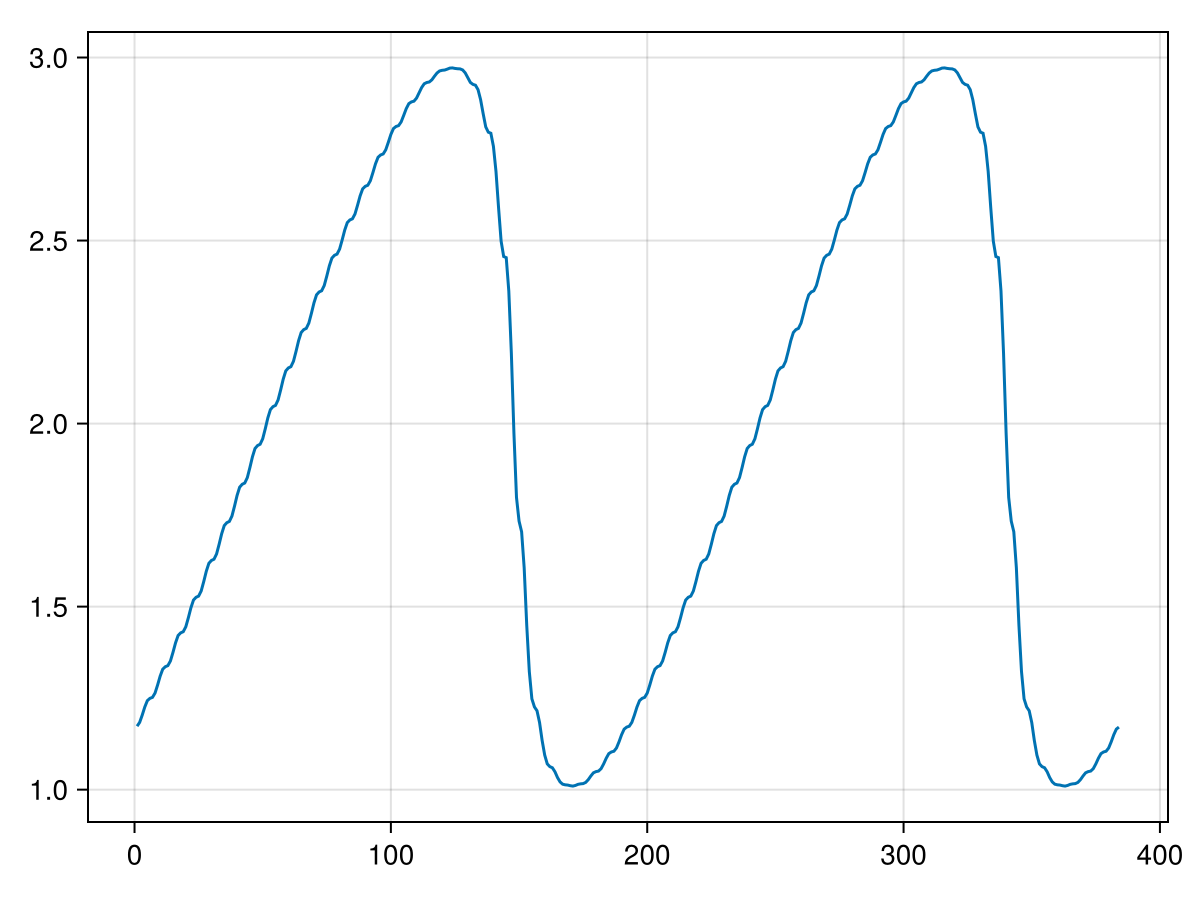

In [8]:
lines(vec(sol.u[100]))

In [9]:
# Print the timer summary
summary_callback()

 ────────────────────────────────────────────────────────────────────────────────
            Trixi.jl                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            28.4s /   0.0%            623MiB /   0.0%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 rhs!                   2.72k   13.3ms  100.0%  4.90μs   13.6KiB  100.0%    5.11B
   volume integral      2.72k   10.9ms   81.3%  3.98μs   6.98KiB   51.4%    2.63B
     blending factors   2.72k   4.78ms   35.8%  1.75μs   1.06KiB    7.8%    0.40B
     pure DG            2.72k   4.71ms   35.3%  1.73μs     0.00B    0.0%    0.00B
     blended DG-FV      2.72k    140μs    1.1%  51.5ns     0.00B    0.0%    0.00B
     ~volume integral~  2.72k   0.00ns    0.0%  0.00ns     0.00B    0.0%    0.00B
   interface fl